In [ ]:
# !mkdir ~/.kaggle
# !mv kaggle.json ~/.kaggle/kaggle.json
# !pip3 install kaggle
# !kaggle datasets download -d sautkin/imagenet1k0

In [ ]:
# !apt-get update
# !apt-get install unzip
# # !mkdir imagenet1k0/
# !unzip -q imagenet1k0.zip -d imagenet1k0/

In [ ]:
# Removing 00220 folders
# !rm -rf imagenet1k0/00220

In [4]:
import os
len(os.listdir("dataset/train"))

100

# **Imports**

In [ ]:
!pip3 install h5py einops tqdm matplotlib 
!pip3 install opencv-python

In [2]:
import os
import shutil
from tqdm.auto import tqdm

# **Preparing Dataset**

In [ ]:
input_path = "imagenet1k0"
out_p = "dataset"


def make_subset(subset, out_path, file_count, start_idx):
    sub_dirs = os.listdir(input_path)
    
    # make folders
    os.makedirs(out_path, exist_ok=True)
    os.makedirs(out_path + f"/{subset}/", exist_ok=True) 
    
    for sdir in tqdm(sub_dirs):
        files = os.listdir(f"{input_path}/{sdir}")
        os.makedirs(out_path  + f"/{subset}/{sdir}/", exist_ok=True)        
        
        total_fc = len(files)
        
        end_idx = None
        if (start_idx + file_count) <= total_fc:
            end_idx = (start_idx + file_count)
        
        for fp in files[start_idx: end_idx]:
            src_path = input_path + f"/{sdir}/{fp}"
            dest_path = out_path  + f"/{subset}/{sdir}/{fp}"
            
            shutil.copyfile(src_path, dest_path) 

In [ ]:
# make_subset("train", out_p, 300, 0) # Make train
make_subset("mini_val", out_p, 30, 300) # Make test

In [5]:
# import shutil

# dir_root = "dataset/mini_val/"

# for x in range(100, 220):
#     directory = dir_root + f"00{str(x)}"
#     shutil.rmtree(directory)
#     print(directory)

shutil.rmtree("dataset/validation")

# **Training Loop**

In [17]:
"""
    Train the models for given saliency map.
"""

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

import os
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from utils.model_loaders import vit_small_patch16_224

np.random.seed(0)
torch.manual_seed(0)


class ModelTrainer:
    def __init__(self, data_path, epochs, batch_size, num_workers, lr, weight_decay) -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        self.save_dir = "custom_trained_models/"
        self.data_path = data_path
        self.train_logs = []


        self.batch_size = batch_size
        self.num_workers = num_workers
        self.epochs = epochs
        
        self.lr = lr
        self.weight_decay = weight_decay
        
        # Model, Optimizer and Loss function setup
        self.model = vit_small_patch16_224(pretrained=False).cuda()

        self.optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)
        self.criterion = CrossEntropyLoss()

        # Data loading and transforms
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        self.dataset = datasets.ImageFolder(root=self.data_path + "/train", transform=self.image_transform)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, drop_last=False)

        self.validation_dataset = datasets.ImageFolder(root=self.data_path + "/mini_val", transform=self.image_transform)
        self.validation_dataloader = DataLoader(self.validation_dataset, batch_size=int(self.batch_size / 2), shuffle=False, num_workers=self.num_workers, drop_last=False)
    
        print(f"{len(self.dataloader) * batch_size } Train Images found")
        print(f"{len(self.validation_dataloader) * batch_size} Validation Images found")
        
        
    """
        Train the model and finally save it.
    """
    def train(self):
        for epoch in range(self.epochs):
            train_loss = 0.0
            val_loss = 0.0
            val_accuracy = 0.0
            
            # Training
            for batch in tqdm(self.dataloader):
                x, y = batch
                x, y = x.cuda(), y.cuda()
                y_hat = self.model(x)
                loss = self.criterion(y_hat, y)
                train_loss += loss.detach().cpu().item() / len(self.dataloader)

                loss.backward()  # backprop calculation
                self.optimizer.step()  # Updating the weight based on these calculation.
                self.optimizer.zero_grad()

                # tqdm._instances.clear()

            # Validation
            for batch in tqdm(self.validation_dataloader):
                xv, yv = batch
                xv, yv = xv.cuda(), yv.cuda()
                yv_hat = self.model(xv)
                vloss = self.criterion(yv_hat, yv)
                
                val_loss += vloss.detach().cpu().item() / len(self.validation_dataloader)
                val_accuracy += self.measure_accuracy(yv_hat, yv) / len(self.validation_dataloader)

                # tqdm._instances.clear()

                
            self.callbacks(train_loss, val_loss, val_accuracy, epoch)

        
    def save_model(self, model_name):
        os.makedirs(self.save_dir, exist_ok=True)
        
        model_path = os.path.join(self.save_dir, f"jx_vit_base_p16_224_{model_name}.pth")
        torch.save(self.model.state_dict(), model_path)
        print(f"Model saved to {model_path}")
        
    def embd_to_class(self, batched_embed):
        class_indices = []
        for embd in batched_embed:
            cls_idx = torch.argmax(embd)
            class_indices.append(cls_idx)
        return torch.Tensor(class_indices)
    
    def measure_accuracy(self, yhat, y):
        yhat_idx = self.embd_to_class(yhat)

        accuracy = 0.0
        for yh, yval in zip(yhat_idx, y):
            accuracy += 1 if (yh == yval) else 0
            
        return accuracy
    

    def callbacks(self, t_loss, v_loss, vacc, epoch):
        self.train_logs.append({'train_loss': t_loss, 'val_loss': v_loss, 'val_accuracy': vacc})
        print(f"""tr_loss: {t_loss:.5f} \t val_loss: {v_loss:.5f} \t val_acc: {vacc:.5f}""")
            
        # Save best model per epoch
        if epoch > 1:
            prev_vl = self.train_logs[-2]['val_loss']
            prev_vacc = self.train_logs[-2]['val_accuracy']

            if vacc >= prev_vacc :
                self.save_model(f"raw_images_{str(epoch)}_max_validation_accuracy")
                print(f"Saved for acc:{vacc}")

            if v_loss <= prev_vl :
                self.save_model(f"raw_images_{str(epoch)}_min_validation_loss")
                print(f"Saved for loss: {v_loss}")

In [2]:
trainer = ModelTrainer(data_path="dataset", epochs=25, batch_size=96, num_workers=1, lr=0.001, weight_decay=0.00004)

30048 Train Images found
6048 Validation Images found


In [ ]:
trainer.train()

In [5]:
print("Training finished")

Training finished


# **Testing**

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

import os
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from utils.model_loaders import vit_small_patch16_224

In [2]:
image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

min_vloss_path = "custom_trained_models/jx_vit_base_p16_224_raw_images_23_min_validation_loss.pth"
max_vacc_path = "custom_trained_models/jx_vit_base_p16_224_raw_images_24_max_validation_accuracy.pth"

In [3]:
validation_dataset = datasets.ImageFolder(root="dataset/mini_val", transform=image_transform)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=1, drop_last=False)

In [4]:
criterion = CrossEntropyLoss()

model = vit_small_patch16_224(pretrained=True, model_path=max_vacc_path).cuda()

In [14]:
def embd_to_class(batched_embed):
    class_indices = []
    for embd in batched_embed:
        cls_idx = torch.argmax(embd)
        class_indices.append(cls_idx)
    return torch.Tensor(class_indices)

def measure_accuracy(yhat, y):
    yhat_idx = embd_to_class(yhat)

    accuracy = 0.0
    for yh, yval in zip(yhat_idx, y):
        accuracy += 1 if (yh == yval) else 0
        
    return accuracy

In [ ]:
val_loss = 0.0
val_accuracy = 0.0

for batch in tqdm(validation_dataloader):
    xv, yv = batch
    xv, yv = xv.cuda(), yv.cuda()
    yv_hat = model(xv)
    vloss = criterion(yv_hat, yv)
    
    val_loss += vloss.detach().cpu().item() / len(validation_dataloader)
    val_accuracy += measure_accuracy(yv_hat, yv) / len(validation_dataloader)


In [7]:
val_loss

4.612114831805229

In [8]:
val_accuracy

0.75

In [16]:
val_loss # max_val_acc

4.618996873497963

In [17]:
val_accuracy # max_val_acc

0.9375

# **Apply Beyond Intuition on this model**

In [37]:
import cv2

def image_vizformat(image):
    t = transforms.Normalize(mean=[-1, -1, -1], std=[1/0.5, 1/0.5, 1/0.5])

    image = t(image)
    img = image[0]
    img = torch.permute(img, (1, 2, 0))
    img = img.detach().cpu()    
    return img

In [39]:
from interpretation_methods import *

heatmaps = []
images = []
lim = 0
for image, label in tqdm(validation_dataloader):
    heatmap, _ = beyond_intuition_tokenwise(model, image, "cuda")
    heatmap = heatmap.reshape((14, 14)).detach().cpu().numpy()
    heatmap = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_NEAREST)
    heatmaps.append(heatmap)

    images.append(image_vizformat(image))

    lim+=1
    if lim > 3:
        break

  0%|          | 0/3000 [00:00<?, ?it/s]

(-0.5, 223.5, 223.5, -0.5)

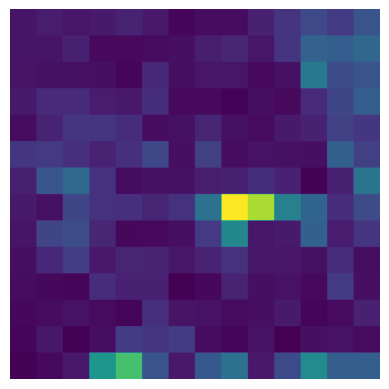

In [40]:
import matplotlib.pyplot as plt

plt.imshow(heatmaps[0])
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

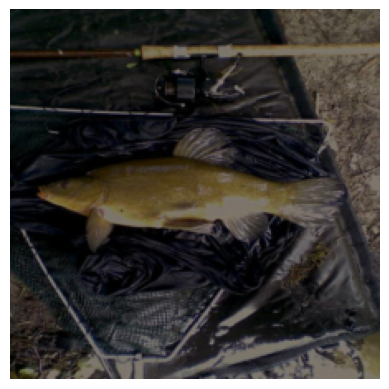

In [41]:
plt.imshow(images[0])
plt.axis("off")

In [1]:
import shutil

In [ ]:
shutil.make_archive("dataset", "zip", "dataset/")

In [ ]:
print("Done")

In [7]:
from tqdm.auto import tqdm
import zipfile
from pathlib import Path

zip_file_path = "dataset.zip"
local_path = "dataset"

with zipfile.ZipFile(zip_file_path, mode="w") as archive:
    for file_path in tqdm(list(Path(local_path).rglob("*")), desc='Adding to Zip '):
        archive.write(
            file_path,
            arcname=file_path.relative_to(local_path)
        )

Adding to Zip :   0%|          | 0/33202 [00:00<?, ?it/s]